In [1]:
import matplotlib.pyplot as plt
from cppbridge import *

In [2]:
%load_ext autoreload
%autoreload 2

All models are from the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
# Linear Gaussian models

## Model specification
We first consider a linear Gaussian state space model for an observed sequence $\mathbf{y}=(y_{1},...,y_{n})$. The model assumes that both observation density and density of unobserved Markov process $\mathbf{X}$ are Gaussian, specified by the following form:
$$\mathbf{x}_{t}=\mathbf{A}_{t}\mathbf{x}_{t-1}+\mathbf{\epsilon}_{t}$$
$$\mathbf{y}_{t}=\mathbf{C}_{t}\mathbf{x}_{t}+\mathbf{\delta}_{t}$$
where
$$\mathbf{\epsilon}_{t}\sim N(0,\mathbf{Q}_{t})$$
$$\mathbf{\delta}_{t}\sim N(0,\mathbf{R}_{t})$$

We assume that the system is stationary, i.e., the parameters $\mathbf{\theta}_{t}=(\mathbf{A}_{t},\mathbf{C}_{t},\mathbf{Q}_{t},\mathbf{R}_{t})$ are independent of time. We will thus drop the subscript $t$ in the future references to these parameters.

### Transition model  
We define the transition Gaussian model as 
$$\mathbf{X}_{t}|x_{t-1}\sim N(\mathbf{A}x_{t-1}, \mathbf{Q}),t=1,...,T$$
with the state at time $t=0$ serving as a prior:
$\mathbf{X}_{0}\sim N(\mathbf{0},\mathbf{Q}_{init})$
We assume the state $\mathbf{X}$ is multidimensional of dimension $n$, with $\mathbf{X}_{t}=(X_{t,1},...,X_{t,n})'$ and set
$$\mathbf{A}=\begin{pmatrix}a_1 & 0 & \cdots & 0\\\ 0 & a_2 & \ddots & \vdots\\\ \vdots & \ddots & a_{n-1} & 0\\\ 0 & \cdots & 0 & a_n \end{pmatrix}$$
$$\mathbf{Q}=\begin{pmatrix}1 & \rho & \cdots & \rho\\\ \rho & 1 & \ddots & \vdots\\\ \vdots & \ddots & 1 & \rho\\\ \rho & \cdots & \rho & 1 \end{pmatrix}$$

$$\mathbf{Q}_{init}=\begin{pmatrix}\frac{1}{1-a_{1}^{2}} & \frac{\rho}{\sqrt{1-a_{1}^{2}}\sqrt{1-a_{2}^{2}}} & \cdots & \frac{\rho}{\sqrt{1-a_{1}^{2}}\sqrt{1-a_{n}^{2}}}\\\ \frac{\rho}{\sqrt{1-a_{2}^{2}}\sqrt{1-a_{1}^{2}}} & \frac{1}{1-a_{2}^{2}} & \ddots & \vdots\\\ \vdots & \ddots & \frac{1}{1-a_{n-1}^{2}} & \frac{\rho}{\sqrt{1-a_{n-1}^{2}}\sqrt{1-a_{n}^{2}}}\\\ \frac{\rho}{\sqrt{1-a_{n}^{2}}\sqrt{1-a_{1}^{2}}} & \cdots & \frac{\rho}{\sqrt{1-a_{n}^{2}}\sqrt{1-a_{n-1}^{2}}} & \frac{1}{1-a_{n}^{2}} \end{pmatrix}$$

For our experiements we use 10-dimensional latent state, with sequence length $T=250$. We set the parameter values as follows:\
$n=10, a_{i}=0.9\text{ for }i=1\ldots n,\text{ and }\rho=0.7$

In [2]:
# Set up the transition model with parameters above
T = 250
n = 10
A = DiagonalMatrixParam() 
A.value = np.eye(n) * 0.9
Q = SymmetricMatrixParam()
Q.value = np.ones((n,n)) * 0.7 + np.eye(n) * 0.3
prior_mean = np.zeros(n)
Q_init = Q.value * (1/(1-0.9*0.9))
trm = TransitionSpec(A, Q, prior_mean, Q_init)

### Observation model
The observation model is also a Gaussian defined as
$$\mathbf{Y}_{t}|x_{t}\sim N(\mathbf{C}x_{t}, \mathbf{R}),t=1,...,T$$

The dimension of the observation is the same as for the latent state. We assume each dimension is indpendent from the other with unit variance, and set the mean coefficients param $\mathbf{C}$ to:
$$\mathbf{C}=\begin{pmatrix}c_1 & 0 & \cdots & 0\\\ 0 & c_2 & \ddots & \vdots\\\ \vdots & \ddots & c_{n-1} & 0\\\ 0 & \cdots & 0 & c_n \end{pmatrix}$$
where $c_{i}=-0.4\text{ for }i=1\ldots n$

In [3]:
# Set up the observation model with parameters above
C = DiagonalMatrixParam()
C.value = -0.4 * np.eye(n)
R = DiagonalMatrixParam()
R.value = np.eye(n)
obsm = ObservationSpec(ModelType.LINEAR_GAUSS, C, R)

## Data generation
Finally, we need the observations, on which to run the samplers and the smoother. The data we use is the synthetic data, generated by the programme using the parameters of the models we specified. To control the output we provide the seed for data generator.

In [4]:
dg = DataGenerator(trm, obsm, T, 200434834)
dg.generate()

The data for these models have been generated already.


---
# Poisson models

## Model specification
Out next model is still Gaussian for unobserved Markov process but the observed sequence now follows a Poisson distribution:
    $$\mathbf{x}_{t}=\mathbf{A}_{t}\mathbf{x}_{t-1}+\mathbf{\epsilon}_{t}$$
$$\mathbf{y}_{t}=\mathbf{\delta}_{t}(\mathbf{x}_{t})$$
where
$$\mathbf{\epsilon}_{t}\sim N(0,\mathbf{Q}_{t})$$
$$\mathbf{\delta}_{t}(\mathbf{x}_{t})\sim \mathrm{Poisson}(\lambda_{t}(\mathbf{x}_{t}))$$

We again assume that the system is stationary, i.e., the parameters $\mathbf{\theta}_{t}=(\mathbf{A}_{t},\mathbf{C}_{t},\mathbf{Q}_{t},\lambda_{t})$ are independent of time and so will drop the subscript $t$ in the future references to these parameters.

For our experiments we will be using two Poisson observation models.


### Transition model
The transition model is the same as in the previous case, with 10-dimensional latent state, same sequence length and the parameters.

### Observation model 1
The first observation model is defined as follows:
$$\mathbf{Y}_{t}|x_{t}\sim \mathrm{Poisson}(\exp(\mathbf{C}\mathbf{x}_{t}+\mathbf{D}\mathbf{u})),\  t=1,...,T,\ i=1,...,n$$
This is a multivariate generalised Poisson model with mean function $e^{\mathbf{\theta}}$ and zero covariance. We will specify the natural parameter $\mathbf{\theta}$ in terms of linear operators $\mathbf{\theta}_{t}=\mathbf{C}\mathbf{x}_{t}+\mathbf{D}\mathbf{u}$, where $\mathbf{C}$ is a diagonal matrix with $C_{i,i}=c_{i}$, $\mathbf{D}$ is a diagonal matrix with $D_{i,i}=d_{i}$ and $\mathbf{u}$ is a vector of all ones.

As before, the dimension of the observation is the same as for the latent state, and we assume each dimension is independent from the other.

For our experiments with this model we will set parameter values as follows:\
$c_{i}=0.6\text{ and }d_{i}=-0.4$.

In [3]:
# Set up the Poisson observation model 1
C = DiagonalMatrixParam()
C.value = 0.6 * np.eye(n)
D = DiagonalMatrixParam()
D.value = -0.4 * np.eye(n)
u = ConstParam(np.ones(n))
obsm_1 = ObservationSpec(ModelType.LINEAR_POISSON, C, D, u)

### Observation model 2
The second observation model is defined as follows:
$$\mathbf{Y}_{t}|x_{t}\sim \mathrm{Poisson}(\mathbf{\sigma}^T|\mathbf{x}_{t}|),\  t=1,...,T,\ i=1,...,n$$

Again, the dimension of the observation is the same as for the latent state, and we assume each dimension is independent from the other.

For the second model we will use 15-dimensional latent state, with sequence length $T=500$, and same transition model parameters and the observation model parameter set at $\sigma_{i}=0.8$.

In [6]:
# Set up the transition model with higher dimension and longer sequence
T2 = 500
n2 = 15
A = DiagonalMatrixParam()
A.value = np.eye(n2) * 0.9
Q = SymmetricMatrixParam()
Q.value = np.ones((n2,n2)) * 0.7 + np.eye(n2) * 0.3
prior_mean = np.zeros(n2)
Q_init = Q.value * (1/(1-0.9*0.9))
trm = TransitionSpec(A, Q, prior_mean, Q_init)

In [7]:
# Set up the observation model 2
sigma = VectorParam()
sigma.value = 0.8 * np.ones(n2)
obsm_2 = ObservationSpec(ModelType.BIMODAL_POISSON, sigma)

## Data generation
As with Gaussian models, we need to generate the observations, on which to run the samplers.

In [4]:
dp1 = DataGenerator(trm, obsm_1, T, 200434834)
dp1.generate()

Launched datagen
Loaded model specifications.
	Generated data saved into ../data/gauss_poiss1_5969728581958258861_data.h5

######### All done #########


In [8]:
dp2 = DataGenerator(trm, obsm_2, T2, 200434834)
dp2.generate()

The data for these models have been generated already.


---
# Visualising generated data
## Linear Gaussian model

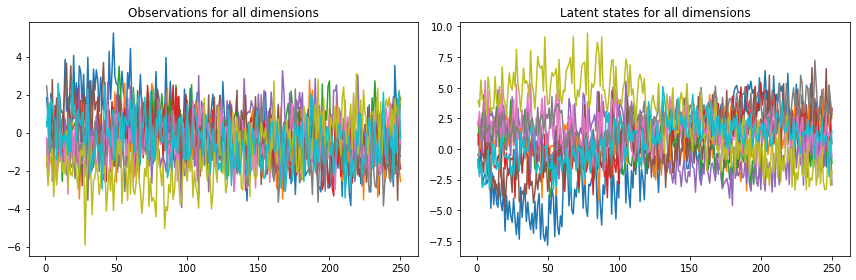

In [11]:
# Plot the states and the generated observations for all dimensions across time
fig, ax = plt.subplots(1, 2, figsize=(12,4))
xs = np.array(range(1, T+1))
for i in range(n):
    ax[0].plot(xs, dg.observations[i, :])
    ax[1].plot(xs, dg.states[i, :])
ax[0].set_title("Observations for all dimensions")
ax[1].set_title("Latent states for all dimensions")
plt.tight_layout()
plt.show();

In [ ]:
df = pd.DataFrame({"means":dg.observations.mean(axis=1), "variances":dg.observations.var(axis=1)}, index=list(range(1,11)))
df = df.append(df.describe().loc[['mean','50%', 'std']])
df

## Linear Poisson model

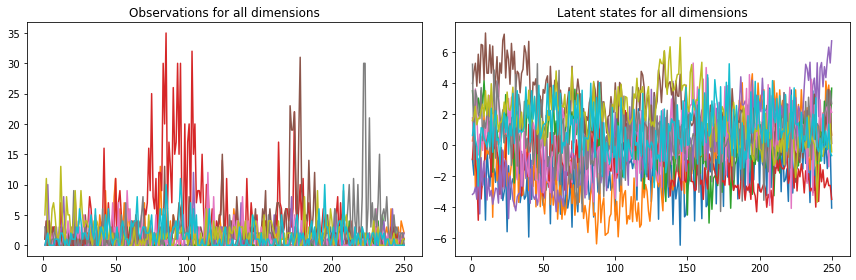

In [12]:
# Plot the states and the generated observations for all dimensions across time
fig, ax = plt.subplots(1, 2, figsize=(12,4))
xs = np.array(range(1, T+1))
for i in range(n):
    ax[0].plot(xs, dp1.observations[i, :])
    ax[1].plot(xs, dp1.states[i, :])
ax[0].set_title("Observations for all dimensions")
ax[1].set_title("Latent states for all dimensions")
plt.tight_layout()
plt.show();

## Bimodal Poisson model

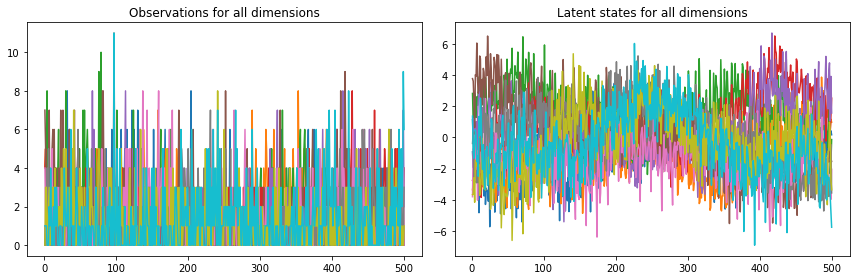

In [9]:
# Plot the states and the generated observations for all dimensions across time
fig, ax = plt.subplots(1, 2, figsize=(12,4))
xs = np.array(range(1, T2+1))
for i in range(n):
    ax[0].plot(xs, dp2.observations[i, :])
    ax[1].plot(xs, dp2.states[i, :])
ax[0].set_title("Observations for all dimensions")
ax[1].set_title("Latent states for all dimensions")
plt.tight_layout()
plt.show();